# **Prepare**

## Import

In [38]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import VimeoVideo
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)

In [31]:
def wrangle(path):
    # Read csv file into dataframe
    df = pd.read_csv(path)

    # Select the features
    df = df[[ 'YEAR', 'DATE', 'TIME', 'HOUR', 'STREET1', 'STREET2', 'ROAD_CLASS', 'DISTRICT', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT',
    'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 
    'PEDCOND',  'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK','TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT',
    'ALCOHOL', 'DISABILITY', 'POLICE_DIVISION','NEIGHBOURHOOD']]


    return df    

In [32]:
path = 'data/KSI.csv'
df = wrangle(path)
print(df.shape)

(16860, 42)


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   YEAR             16860 non-null  int64 
 1   DATE             16860 non-null  object
 2   TIME             16860 non-null  int64 
 3   HOUR             16860 non-null  int64 
 4   STREET1          16860 non-null  object
 5   STREET2          16860 non-null  object
 6   ROAD_CLASS       16860 non-null  object
 7   DISTRICT         16860 non-null  object
 8   LOCCOORD         16860 non-null  object
 9   ACCLOC           16860 non-null  object
 10  TRAFFCTL         16860 non-null  object
 11  VISIBILITY       16860 non-null  object
 12  LIGHT            16860 non-null  object
 13  RDSFCOND         16860 non-null  object
 14  ACCLASS          16860 non-null  object
 15  IMPACTYPE        16860 non-null  object
 16  INVTYPE          16860 non-null  object
 17  INVAGE           16860 non-null

In [34]:
df.describe()

,YEAR,TIME,HOUR
count,16860.000000,16860.000000,16860.000000
mean,2012.256168,1352.106821,13.241103
std,4.252797,629.726747,6.302679
min,2006.000000,0.000000,0.000000
25%,2009.000000,913.000000,9.000000
50%,2012.000000,1442.000000,14.000000
75%,2016.000000,1845.000000,18.000000
max,2020.000000,2359.000000,23.000000


In [35]:
df.head().transpose()

,0,1,2,3,4
YEAR,2006,2006,2006,2006,2006
DATE,2006/03/11 05:00:00+00,2006/03/11 05:00:00+00,2006/03/11 05:00:00+00,2006/03/11 05:00:00+00,2006/03/12 05:00:00+00
TIME,852,852,915,915,240
HOUR,8,8,9,9,2
STREET1,BLOOR ST W,BLOOR ST W,MORNINGSIDE AVE,MORNINGSIDE AVE,EGLINTON AVE E
STREET2,DUNDAS ST W,DUNDAS ST W,SHEPPARD AVE E,SHEPPARD AVE E,COMMONWEALTH AVE
ROAD_CLASS,Major Arterial,Major Arterial,Major Arterial,Major Arterial,Major Arterial
DISTRICT,Toronto and East York,Toronto and East York,Scarborough,Scarborough,Scarborough
LOCCOORD,Intersection,Intersection,Intersection,Intersection,Mid-Block
ACCLOC,At Intersection,At Intersection,At Intersection,At Intersection,No


## Explore

### Descriptive Analysis ( Exploratory Data Analysis)


#### Uni-variate Analysis (Comparing 1 variable at a time)

In [45]:
def conut_feature(df, xlabel):
    ax = sns.countplot(x=df)

    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14)
    plt.yticks(size=12)
    plt.ylabel('Number of Traffic Collisions', size=12)
    plt.title("Percentage of Traffic Collision", size=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.tight_layout()
    plt.show()

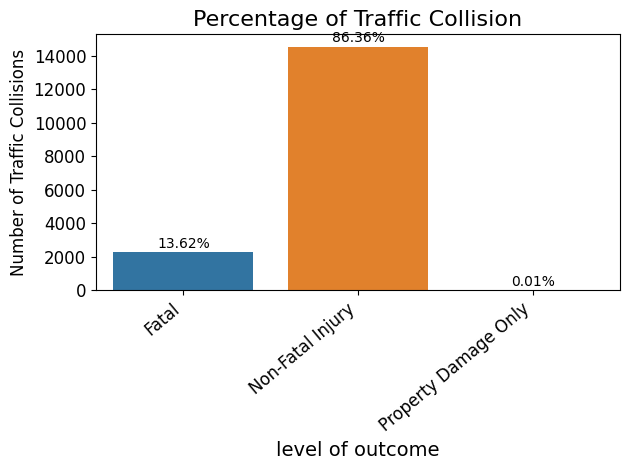

In [46]:
# What is the percentage of OUTCOME?
conut_feature(df['ACCLASS'], 'level of outcome')

## Split

# **Build Model**

## Baseline

## Iterate

In [ ]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=600,  # Width of map
    height=600,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [ ]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x='lon',
    y='lat',
    z='price_aprox_usd',
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

## Evaluate

# **Communicate Results**